In [1]:
import sys, os
import warnings
import h5py
import numpy as np
from joblib import delayed, Parallel
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
from sklearn.metrics import pairwise_distances

from scipy.stats._stats import _center_distance_matrix

sys.path.append(os.path.realpath('..'))

In [2]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import pairwise_distances

from scipy.stats.distributions import chi2
from hyppo.independence.base import IndependenceTest
from hyppo.independence.dcorr import _dcorr
from hyppo.independence._utils import sim_matrix


FOREST_TYPES = {
    "classifier" : RandomForestClassifier,
    "regressor" : RandomForestRegressor
}


class KMERF(IndependenceTest):
    r"""
    Class for calculating the random forest based Dcorr test statistic and p-value.
    """

    def __init__(self, forest="regressor", ntrees=500, **kwargs):
        if forest in FOREST_TYPES.keys():
            self.clf = FOREST_TYPES[forest](n_estimators=ntrees, **kwargs)
        else:
            raise ValueError("forest must be one of the following ")
        IndependenceTest.__init__(self)

    def statistic(self, x, y):
        r"""
        Helper function that calculates the random forest based Dcorr test statistic.
        """
        rf_y = y.ravel()
        if y.shape[1] == 1:
            rf_y = y.ravel()
        self.clf.fit(x, rf_y)
        distx = np.sqrt(1 - sim_matrix(self.clf, x))
        if x.shape[1] == y.shape[1]:
            disty = np.sqrt(1 - sim_matrix(self.clf, y))
        else:
            disty = pairwise_distances(
                y, metric="euclidean"
            )
        stat = _dcorr(distx, disty, bias=False, is_fast=False)

        return stat
    
    def test(self, x, y):
        n = x.shape[0]
        stat = self.statistic(x, y)
        statx = self.statistic(x, x)
        staty = self.statistic(y, y)
        pvalue = chi2.sf(stat / np.sqrt(statx * staty) * n + 1, 1)
        return stat, pvalue

In [3]:
sns.set(color_codes=True, style='white', context='talk', font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE)

In [4]:
# import mat file
arrays = {}
f = h5py.File("../kmerf/real_data/proteomics.mat")
for k, v in f.items():
    arrays[k] = np.array(v)

In [5]:
def compute_pvalue(D, A, per, i):
    C = A[per.ravel(), i]
    return KMERF().test(C.reshape(-1, 1), D.reshape(-1, 1))[1]


def generate_perd(labelindall, vs_type):
    if vs_type == "pancvsnormal":
        per = np.logical_or(labelindall == 1, labelindall == 2)
    elif vs_type == "pancvsall":
        per = np.logical_and(labelindall != 2, labelindall < 5)
        labelindall[per] = 1
        per = labelindall < 5
    else:
        raise ValueError("vs_type must be pancvsnormal or pancvsall")
        
    D = labelindall[per]
        
    return per, D


def generate_pvalues(arrays, vs_type="pancvsnormal"):
    labelindall = arrays['LabelIndAll']
    A = arrays['A']
    
    per, D = generate_perd(labelindall, vs_type)
    
    pvalues = Parallel(n_jobs=-1, verbose=100)(
        [delayed(compute_pvalue)(D, A, per, i) for i in range(A.shape[1])]
    )
    return pvalues

In [6]:
panc_vs_normal = generate_pvalues(arrays, vs_type="pancvsnormal")
np.savetxt('../kmerf/real_data/panc_vs_normal.csv', panc_vs_normal, delimiter=',')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  

[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  2.0min
[Paralle

[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 283 tasks      | elapsed:  2.7min
[Paralle

In [7]:
panc_vs_all = generate_pvalues(arrays, vs_type="pancvsall")
np.savetxt('../kmerf/real_data/panc_vs_all.csv', panc_vs_all, delimiter=',')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  

[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:   49.3s
[Paralle

[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 283 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 285 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 286 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 287 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 291 out of 318 | elapsed:  1.5min remainin

In [116]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut

# Load the data
X = arrays['A']
labelind = arrays['LabelInd'].ravel()
y = np.array([1 if label == 2 else 0 for label in labelind])

# Create the cross validator
cv = LeaveOneOut()

# Create the classifier
clf = KNeighborsClassifier(n_neighbors=10)

# Fit the classifier
for train_index, test_index in cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)

# Evaluate the classifier
scores = []
for train_index, test_index in cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    scores.append(clf.predict(X_test))

scores = np.array(scores).ravel()
panc_ind = np.where(y == 1)[0]
print('Score:', scores[panc_ind] == y[panc_ind])

Score: [False False False False False False False False False]


In [150]:
def plot_real_data():
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    
    panc_vs_normal = np.genfromtxt('../kmerf/real_data/panc_vs_normal.csv', delimiter=',')
    panc_vs_all = np.genfromtxt('../kmerf/real_data/panc_vs_all.csv', delimiter=',')
    
    ax1.scatter(panc_vs_normal, panc_vs_all, c="#4daf4a", s=75)
    ax1.scatter(panc_vs_normal[180], panc_vs_all[180], c="#e41a1c", s=100)
    ax1.text(panc_vs_normal[180]+1e-6, panc_vs_all[180]+1e-6, c="#e41a1c", s="neurogranin")
#     ax1.axhline(y=1e-3, linestyle='--')
#     ax1.axvline(x=1e-5, linestyle='--')
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax1.set_xlabel("p-values for Panc vs Norm")
    ax1.set_ylabel("p-values for Panc vs All")
#     ax1.set_xticks([1e-2, 1e-1, 1e0])
#     ax1.set_yticks([1e-2, 1e-1, 1e0])
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_title('Cancer Biomarker Discovery', pad=20)
    
    # See https://elifesciences.org/articles/41690#fig4
    # Same peptide identified, so identical tp/fp
    labels = ["False Positives", "True Positives"]
    data = {
        'KMERF': ([2, 5], "#e41a1c"),
        'Hsic': ([4, 5], "#4daf4a"),
        'HHG' : ([2, 1], "#984ea3"),
        'Other' : ([9, 0], "#ff7f00"),
    }
    x = np.arange(len(labels))  # the label locations
    width = 0.15  # the width of the bars
    multiplier = 0

    for test, positives in data.items():
        offset = width * multiplier
        rects = ax2.bar(x + offset, positives[0], width, color=positives[1], label=test)
        multiplier += 1
        
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax2.set_ylabel("# True / False Positives")
    ax2.set_ylim([0, 10])
    ax2.set_xticks(x + width + width/2)
    ax2.set_xticklabels(labels)
    plt.legend()
    ax2.set_title('Biomarker kNN Classification', pad=20)
    leg = plt.legend(bbox_to_anchor=(0.8, 0.9), bbox_transform=plt.gcf().transFigure,
                     ncol=1, loc='upper center', labelspacing=.1)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    plt.subplots_adjust(wspace=0.3)
    plt.savefig('../kmerf/figs/real_data.pdf', transparent=True, bbox_inches='tight')

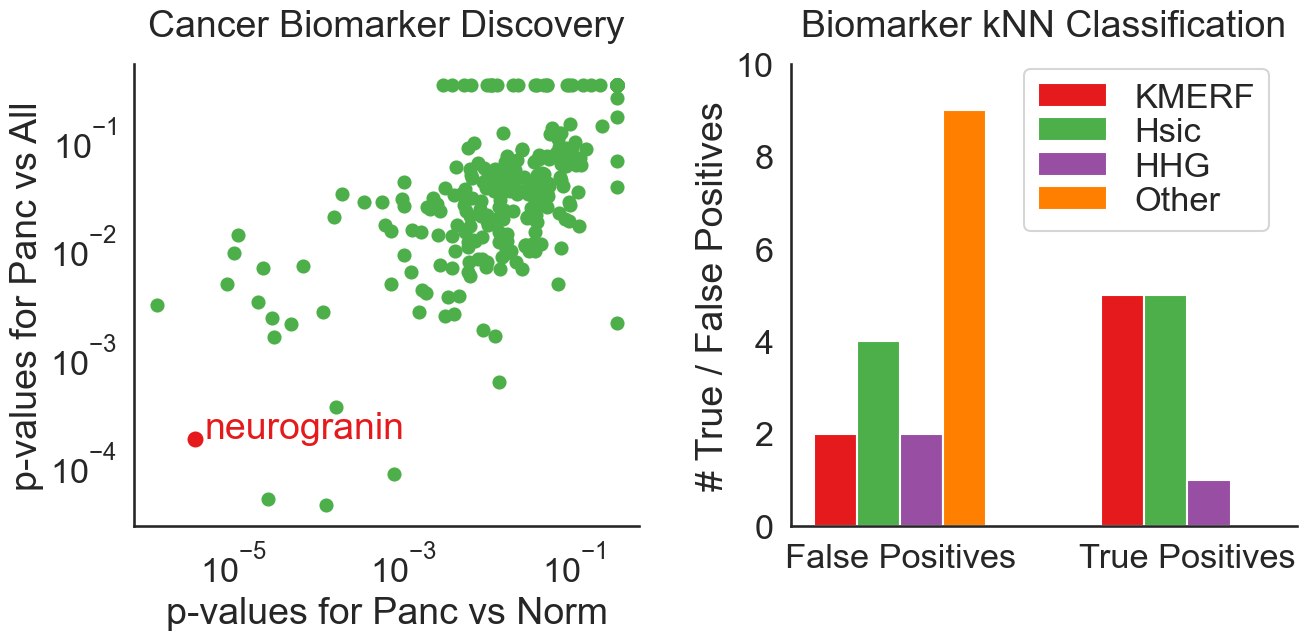

In [151]:
plot_real_data()